In [52]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro,f_oneway
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import scipy.interpolate as interp
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [3]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [4]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd,F,B,F0,F1,B0,B1 = pickle.load(file)

In [ ]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
# conditions = ['0','0.25','0.5','0.75','1']
conditions = ['0','25','50','75','100']
# conditions = ['0:1','1:3','1:1','3:1','1:0']
# conditions = ['0:1','1:3','1:1','3:1','1:0']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


## Bode plots

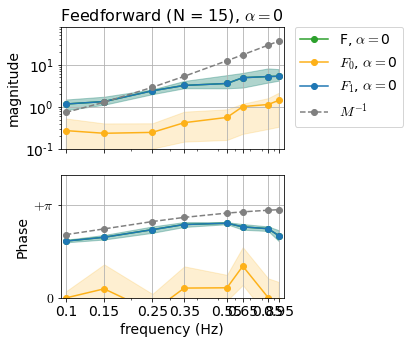

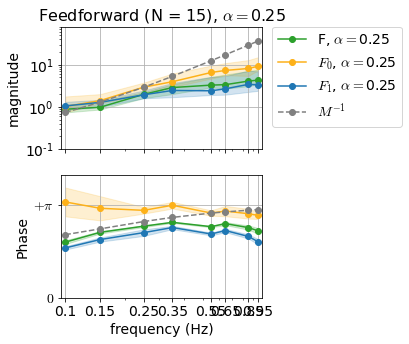

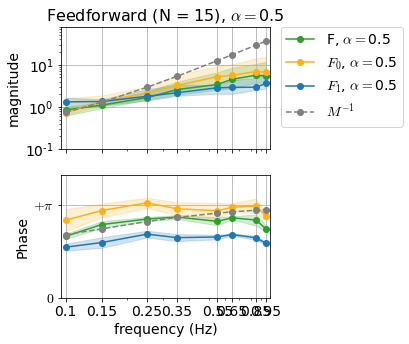

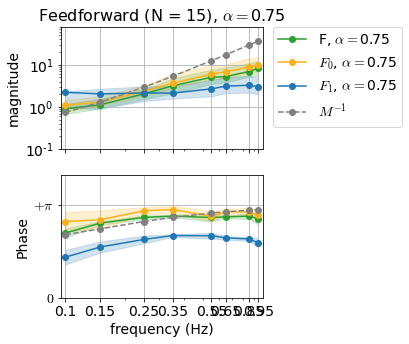

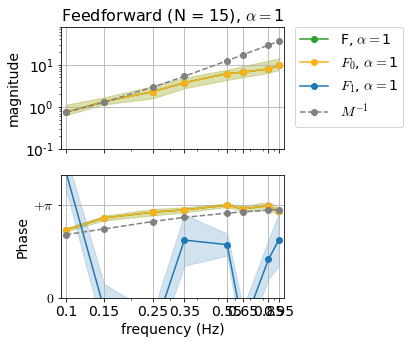

In [8]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(6,5))
    # F
    mean = np.mean(np.abs(F[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'F, $\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GREEN'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

    # F0
    F_mean = np.mean(np.abs(F0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# F0 and F1 in multimodal vs single-modal

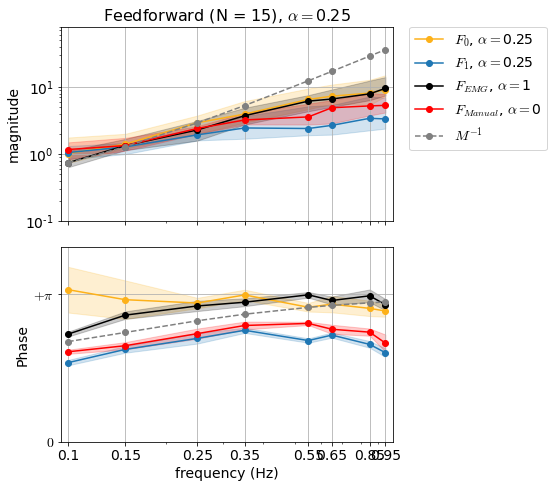

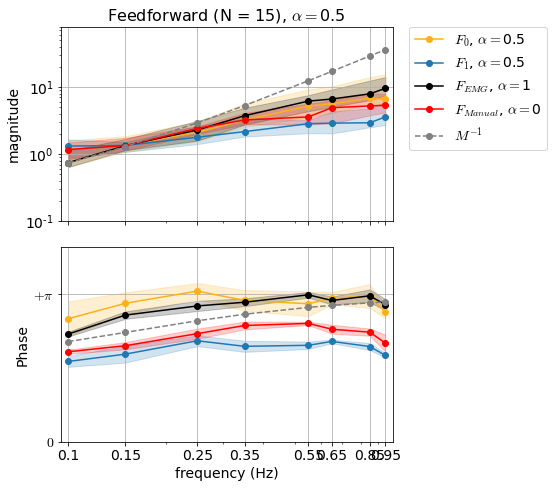

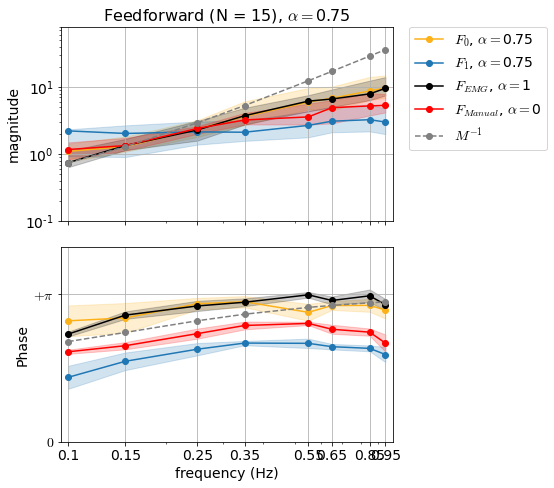

In [14]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in [1,2,3]:

    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))


    # F0
    F_mean = np.mean(np.abs(F0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    # F_EMG-only
    F_mean = np.mean(np.abs(F0[:,4,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_{EMG}$, $\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,4,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    # F_Manual-only
    F_mean = np.mean(np.abs(F1[:,0,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$F_{Manual}$, $\alpha = $'+conditions[0],color = 'red')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'red')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,0,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[0],color = 'red')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'red')

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

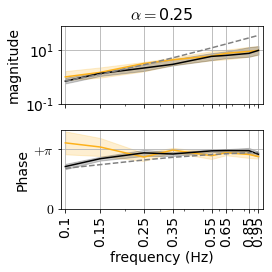

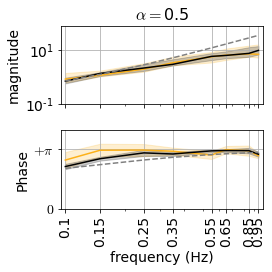

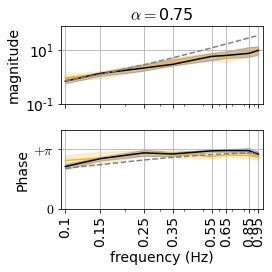

In [23]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
last_few_trials = 5 # trial)num//2

for cond in [1,2,3]:
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(4,4))

    # F0
    F_mean = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_0$, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F_EMG-only
    F_mean = np.mean(np.abs(F0[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_{EMG}$, $\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,4,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0].set_title(r'$\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

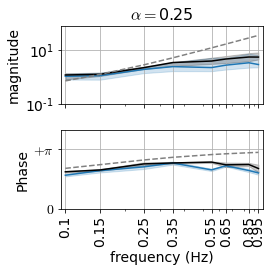

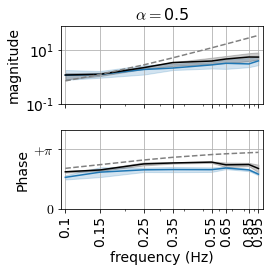

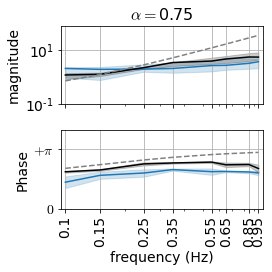

In [24]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
last_few_trials = 5 # trial)num//2

for cond in [1,2,3]:
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(4,4))

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_1$, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    # F_Manual-only
    F_mean = np.mean(np.abs(F1[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-',label = r'$F_{Manual}$, $\alpha = $'+conditions[0],color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,0,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[0],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0].set_title(r'$\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# boxplots F

In [78]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = F[:,:,-last_trials:,:stim_below] #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs

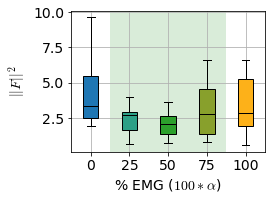

In [79]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||F||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [80]:
# Conduct the one-way ANOVA
f_oneway(datas[0],datas[1],datas[2],datas[3],datas[4]) #see if p < 0.05

F_onewayResult(statistic=1.7464980095078373, pvalue=0.1495495157702676)

# boxplots F0

In [63]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = F0[:,:,-last_trials:,:stim_below] #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
datas = datas[1:]

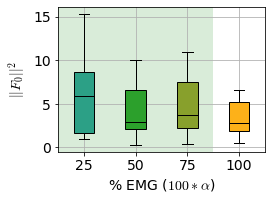

In [64]:
labels = conditions[1:] #slider : EMG
boxcolors = ['#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(0.5,3.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||F_0||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [65]:
# Conduct the one-way ANOVA
f_oneway(datas[0],datas[1],datas[2],datas[3]) #see if p < 0.05

F_onewayResult(statistic=0.7105522483519369, pvalue=0.5497773086383042)

# boxplots F1

In [70]:
datas = []
last_trials = 5 # 10//2
stim_below = 3

TF = F1[:,:,-last_trials:,:stim_below] #at stim below 0.25 Hz
for cond in range(condition_num):
    datas.append( np.mean((np.abs(TF[:,cond,:,:]))**2, axis = (1,2)) )#mean across all trials and freqs
datas = datas[:-1]

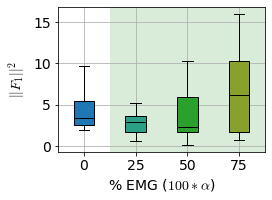

In [71]:
labels = conditions[:-1] #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c']

fig,ax = plt.subplots(figsize=(4,3))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel('Manual : EMG',fontsize = 14) #add x axis labels
ax.set_xlabel(r'% EMG ($100*\alpha$)',fontsize = 14) #add x axis labels
face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)
ax.set_ylabel(r'$||F_1||^2$',fontsize = 14) # add y axis label
ax.grid('on',zorder=-1)
# ax.set_title('average |R-Y| below crossover freqs (N = 15)')
plt.tight_layout()
# fig.savefig('example_sub1.svg')
plt.show()

In [72]:
# Conduct the one-way ANOVA
f_oneway(datas[0],datas[1],datas[2],datas[3]) #see if p < 0.05

F_onewayResult(statistic=3.378429632539739, pvalue=0.02445213681884442)

In [73]:
WilcoxonTest(datas)

(array([nan, 17., 31., 44., 17., nan, 31., 14., 31., 31., nan, 18., 44.,
        14., 18., nan]),
 array([       nan, 0.01245117, 0.10699463, 0.3894043 , 0.01245117,
               nan, 0.10699463, 0.00671387, 0.10699463, 0.10699463,
               nan, 0.01507568, 0.3894043 , 0.00671387, 0.01507568,
               nan]),
 array([nan,  1.,  0.,  0.,  1., nan,  0.,  1.,  0.,  0., nan,  1.,  0.,
         1.,  1., nan]),
 ['there is significant difference between condition 0 and condition 1, w = 17.0, pvalue = 0.012451171875',
  'there is significant difference between condition 1 and condition 3, w = 14.0, pvalue = 0.0067138671875',
  'there is significant difference between condition 2 and condition 3, w = 18.0, pvalue = 0.01507568359375'])